<h2 style="display:inline;"> Turning </h2> 
<img src="img/pymc3.jpg" alt="pymc3_logo" style="width: 200px;display:inline;"/>
<h2 style="display:inline;"> into </h2>
<img src="img/sklearn.png" alt="sklearn_logo" style="width: 150px;display:inline;"/>

<h3>
Nicole Carlson <br>
@parsing_science <br>
github.com/parsing-science
</h3>

In [1]:
import pickle

import numpy as np
from pymc3 import summary, traceplot
import pymc3 as pm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import theano.tensor as T

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

Motivating Example: Scikitlearn
===

<h1> Generate Fake Data </h1>

In [3]:
X = np.random.randn(1000, 10)
Y = np.random.randn(1000,)

<h1> Create a LinearRegression instance and use it </h1>

In [4]:
LR = LinearRegression()

In [5]:
LR.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
X_predict = LR.predict(X)

In [7]:
LR.score(X, Y)

0.0080268849259235164

<h1> Save and Load LR </h1>

In [8]:
pickle.dump(LR, open('LR.pickle', 'wb'))

In [9]:
saved_LR = pickle.load(open('LR.pickle', 'rb'))

In [10]:
saved_LR.score(X, Y)

0.0080268849259235164

Intro to PyMC3
===

- Library for Probabilistic Modeling
- MCMC Samplers
- Variational Fitting Algorithms
- Built on top of Theano
- Completely written in Python

<h1> Set up the PyMC model </h1>

In [11]:
lin_reg_model = pm.Model()
with lin_reg_model:

    alpha = pm.Normal('alpha', mu=0, tau=10.**-2, shape=(1))
    betas = pm.Normal('betas', mu=0, tau=10. ** -2, shape=(1, 10))
    
    s = pm.HalfNormal('s', tau=1)
    
    temp = alpha + T.dot(betas, X.T)

    y = pm.Normal('y', mu=temp , tau=s ** -2, observed=Y)

<h1> Sample from the model </h1>

In [12]:
with lin_reg_model:
    step = pm.NUTS()
    nuts_trace = pm.sample(2e3, step)

100%|██████████| 2000/2000.0 [00:05<00:00, 367.17it/s]


<h1> Create posterior predictive samples </h1>

In [13]:
ppc = pm.sample_ppc(nuts_trace[1000:], model=lin_reg_model, samples=1000)

100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


In [14]:
pred = ppc['y'].mean(axis=0).T

In [15]:
r2_score(Y, pred)

0.0074139356065737738

<h1> Most PyMC3 Examples </h1>

* Exist in Jupyter notebooks
* Focus on training a model with one dataset
* Don’t demonstrate how to predict new data
* Don’t show how to save your model for later use



<h1> Comparing the two libraries </h1>

<table>
<tr>
<th> </th>
<th>sklearn</th>
<th>PyMC3</th>
</tr>
<tr>
<th>Find model parameters</th>
<th>Easy</th>
<th>Medium</th>
</tr>
<tr>
<th>Predict new data</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Score a model</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Save a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
<tr>
<th>Load a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
</table>


<h1> What we want to reproduce in PyMC3 </h1>

* fit
* predict
* score
* save
* load


<h1> Initializing the HLM class </h1>

In [ ]:
class HLM(BaseEstimator):
    """
    Custom Hierachical Linear Model built using PyMC3.
    """

    def __init__(self):
        self.cached_model = None
        self.shared_vars = None
        self.num_cats = None
        self.num_pred = None
        self.advi_trace = None
        self.v_params = None

<h1> Fit </h1>

In [ ]:
def fit(self, X, cats, y):
    """
    Train the HLM model

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]

    y : numpy array, shape [n_samples, ]
    """
    self.num_cats = len(np.unique(cats))
    num_samples, self.num_pred = X.shape

    if self.cached_model is None:
        self.cached_model, o = self.create_model()

    minibatch_tensors = [
        self.shared_vars['model_input'],
        self.shared_vars['model_output'],
        self.shared_vars['model_cats']
    ]
    minibatch_RVs = [o]

    minibatches = self._create_minibatch([X, y, cats], num_samples)

    self.v_params, self.advi_trace = self._inference(
        minibatch_tensors,
        minibatch_RVs,
        minibatches,
        num_samples
    )

    return self

<h1> Create the model </h1>

In [ ]:
def create_model(self):
    """
    Creates and returns the PyMC3 model.

    Returns the model and the output variable. The latter is for use in ADVI minibatch.
    """
    model_input = theano.shared(np.zeros([1, self.num_pred]))

    model_output = theano.shared(np.zeros(1))

    model_cats = theano.shared(np.zeros(1, dtype='int'))

    self.shared_vars = {'model_input': model_input, 'model_output': model_output, 'model_cats': model_cats}

    model = pm.Model()

    with model:
        # Both alpha and beta are drawn from Normal distributions
        mu_alpha = pm.Normal("mu_alpha", mu=0, sd=10)
        sigma_alpha = pm.HalfNormal("sigma_alpha", sd=10)

        mu_beta = pm.Normal("mu_beta", mu=0, sd=10)
        sigma_beta = pm.HalfNormal("sigma_beta", sd=10)

        alpha = pm.Normal('alpha', mu=mu_alpha, sd=sigma_alpha, shape=(self.num_cats,))
        beta = pm.Normal('beta', mu=mu_beta, sd=sigma_beta, shape=(self.num_cats, self.num_pred))

        c = model_cats

        temp = alpha[c] + T.sum(beta[c] * model_input, 1)

        p = pm.invlogit(temp)

        o = pm.Bernoulli('o', p, observed=model_output)

    return model, o

<h1> Create minibatches for ADVI </h1>

In [ ]:
@staticmethod
def _create_minibatch(data, num_samples, size=100):
    """
    Generator that returns mini-batches in each iteration
    """
    while True:
        # Return random data samples of set size each iteration
        ixs = np.random.randint(num_samples, size=size)
        yield [tensor[ixs] for tensor in data]

<h1> Inference </h1>

In [ ]:
def _inference(self, minibatch_tensors, minibatch_RVs, minibatches, num_samples):
    """
    Runs minibatch variational ADVI and then sample from those results.
    """
    with self.cached_model:
        v_params = pm.variational.advi_minibatch(
            n=50000,
            minibatch_tensors=minibatch_tensors,
            minibatch_RVs=minibatch_RVs,
            minibatches=minibatches,
            total_size=int(num_samples),
            learning_rate=1e-2,
            epsilon=1.0
        )

        advi_trace = pm.variational.sample_vp(v_params, draws=7500)

    return v_params, advi_trace

<h1> Predict </h1>

In [ ]:
def predict(self, X, cats):
    """
    Predicts labels of new data with a trained HLM

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]
    """
    ppc_mean = self.predict_proba(X, cats)

    pred = ppc_mean > 0.5

    return pred

<h1> Predict Probabilities </h1>

In [ ]:
def predict_proba(self, X, cats):
    """
    Predicts probabilities of new data with a trained HLM

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]
    """

    if self.advi_trace is None:
        raise PSToolkitError("Run fit on the model before predict.")

    num_samples = X.shape[0]

    if self.cached_model is None:
        self.cached_model, o = self.create_model()

    self._set_shared_vars(X, np.zeros(num_samples), cats)

    ppc = pm.sample_ppc(self.advi_trace, model=self.cached_model, samples=2000)

    return ppc['o'].mean(axis=0)

<h1> Set Shared Variables </h1>

In [ ]:
def _set_shared_vars(self, model_input, model_output, model_cats):
    """
    Creates theano shared variables for the PyMC3 model.
    """
    self.shared_vars['model_input'].set_value(model_input)

    self.shared_vars['model_output'].set_value(model_output)

    self.shared_vars['model_cats'].set_value(model_cats)

<h1> Score </h1>

In [ ]:
def score(self, X, cats, y):
    """
    Scores new data with a trained model.

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]

    y : numpy array, shape [n_samples, ]
    """
    return accuracy_score(y, self.predict(X, cats))


<h1> Save </h1>

In [ ]:
def save(self, file_prefix):
    """
    Saves the advi_trace, v_params, and param files with the given file_prefix.

    Parameters
    ----------
    file_prefix: str
    path and prefix used to identify where to save trace and params for this model.
    ex. given file_prefix = "path/to/file/"
    This will attempt to save to "path/to/file/advi_trace.pickle" and "path/to/file/params.pickle"
    """
    fileObject = open(file_prefix + "advi_trace.pickle", 'w')
    joblib.dump(self.advi_trace, fileObject)
    fileObject.close()

    fileObject = open(file_prefix + "v_params.pickle", 'w')
    joblib.dump(self.v_params, fileObject)
    fileObject.close()

    fileObject = open(file_prefix + "params.pickle", 'w')
    joblib.dump(
        {"num_cats": self.num_cats, "num_pred": self.num_pred},
        fileObject
    )
    fileObject.close()

<h1> Load </h1>

In [ ]:
def load(self, file_prefix):
    """
    Loads a saved version of the advi_trace, v_params, and param files with the given file_prefix.

    Parameters
    ----------
    file_prefix: str
    path and prefix used to identify where to load saved trace and params for this model.
    ex. given file_prefix = "path/to/file/"
    This will attempt to load "path/to/file/advi_trace.pickle" and "path/to/file/params.pickle"
    """
    self.advi_trace = joblib.load(file_prefix + "advi_trace.pickle")
    self.v_params = joblib.load(file_prefix + "v_params.pickle")

    params = joblib.load(file_prefix + "params.pickle")
    self.num_cats = params["num_cats"]
    self.num_pred = params["num_pred"]

Custom PyMC3 Class
===

<h1> Generate Fake Data </h1>

In [16]:
num_predictors = 5
num_samples = 500
num_categories = 3

In [17]:
fake_X = np.random.randn(num_samples, num_predictors)

In [18]:
fake_Y = np.random.randint(2, size=(num_samples,))

In [19]:
fake_cats = np.random.randint(num_categories, size=(num_samples,))

<h1> Load the class </h1>

In [20]:
from ps_toolkit import HLM

In [21]:
HLM1 = HLM()

In [22]:
warnings.filterwarnings(action="ignore", module="theano", message="^theano.tensor.round")

<h1> Fit the HLM </h1>

In [23]:
HLM1.fit(fake_X, fake_cats, fake_Y)

Average ELBO = -368.39: 100%|██████████| 50000/50000 [00:32<00:00, 1550.62it/s]
Finished minibatch ADVI: ELBO = -373.78
100%|██████████| 7500/7500 [00:00<00:00, 7523.53it/s]


HLM()

<h1> Predict and score the model </h1>

In [24]:
probs = HLM1.predict_proba(fake_X, fake_cats)

100%|██████████| 2000/2000 [00:08<00:00, 252.28it/s]


In [25]:
pred = HLM1.predict(fake_X, fake_cats)

100%|██████████| 2000/2000 [00:08<00:00, 241.20it/s]


In [26]:
HLM1.score(fake_X, fake_cats, fake_Y)

100%|██████████| 2000/2000 [00:08<00:00, 258.69it/s]


0.56399999999999995

<h1> Save and Load the model </h1>

In [27]:
HLM1.save("HLM_jar/")

In [28]:
HLM2 = HLM()

In [29]:
HLM2.load("HLM_jar/")

In [30]:
HLM2.score(fake_X, fake_cats, fake_Y)

100%|██████████| 2000/2000 [00:08<00:00, 236.31it/s]


0.55800000000000005

Bonus: Checking model fit
===

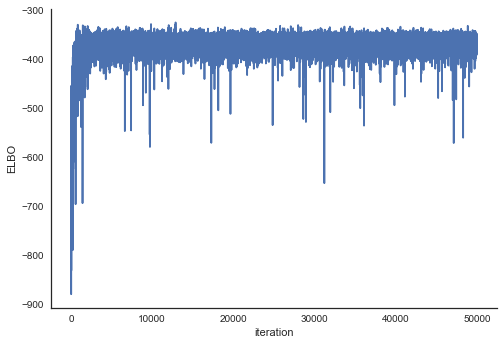

In [31]:
HLM1.plot_elbo()

In [32]:
summary(HLM1.advi_trace)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.014            0.186            0.002            [-0.346, 0.378]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.347         -0.112         0.014          0.139          0.378


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.020            0.052            0.001            [-0.084, 0.117]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.082         -0.016         0.020          0.054          0.120


alpha:

  Mean             SD               MC Error         95% HPD interval
  ------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139d701d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13ae7de90>]], dtype=object)

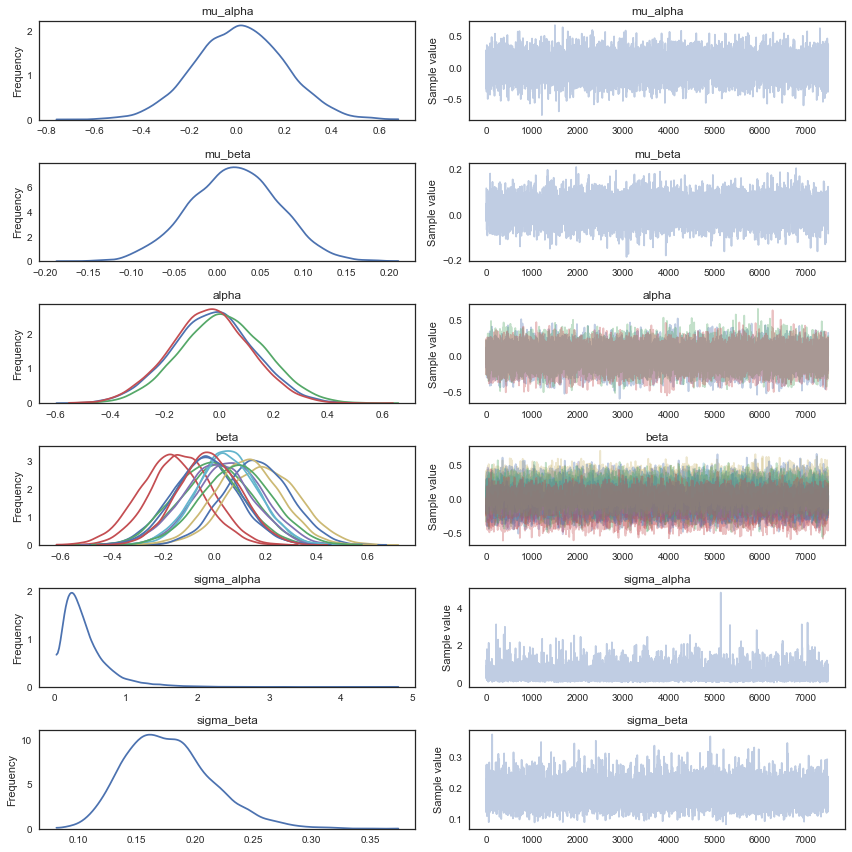

In [33]:
traceplot(HLM1.advi_trace)

<h1> Next Steps </h1>
* Build Bayesian Model base class 
* Pass more options to the init function
* Test if this class can be used in an sklearn pipeline


<h1> Thanks! </h1>